In [1]:
import tensorflow as tf

tf.enable_eager_execution()

tfe = tf.contrib.eager

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import warnings

warnings.filterwarnings("ignore")

In [180]:
from util import silhouette_plot, cluster_stability
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# Preprocess DataFrame

In [4]:
df_main = pd.read_csv("zip_code_age_lg_wealth_osm_percentage.csv", index_col="Unnamed: 0")
df_main = df_main.drop(index=10020)  # missing all the data
df_main.head(2)

,female[0-9],male[0-9],female[10-19],male[10-19],female[20-29],male[20-29],female[30-39],male[30-39],female[40-49],male[40-49],...,"50,000-75,000","75,000-100,000","100,000-200,000","200,000-...",stadium_count,shoes_count,restaurant_count,gym_count,clothes_count,clinic_count
10026,0.059201,0.056966,0.058436,0.059289,0.094345,0.08111,0.092021,0.078905,0.083287,0.079199,...,0.136957,0.078261,0.100000,0.053261,0.0,0.0,18.0,0.0,0.0,1.0
10027,0.050966,0.050011,0.077194,0.067228,0.131140,0.10853,0.077478,0.069054,0.066776,0.061601,...,0.126863,0.064340,0.086514,0.046529,0.0,2.0,25.0,4.0,5.0,1.0


In [5]:
for osm in ['stadium', 'shoes', 'restaurant', 'gym', 'clothes', 'clinic']:
    col_name = f'{osm}_count'
    sparsity = np.sum(df_main[col_name]==0) / df_main.shape[0]
    print(f'{osm} sparsity: {sparsity}')

stadium sparsity: 0.9193548387096774
shoes sparsity: 0.43548387096774194
restaurant sparsity: 0.04838709677419355
gym sparsity: 0.5
clothes sparsity: 0.3870967741935484
clinic sparsity: 0.43548387096774194


In [6]:
mask = df_main.columns[df_main.columns!='stadium_count']
df_main = df_main[mask]
df_main.shape

(62, 26)

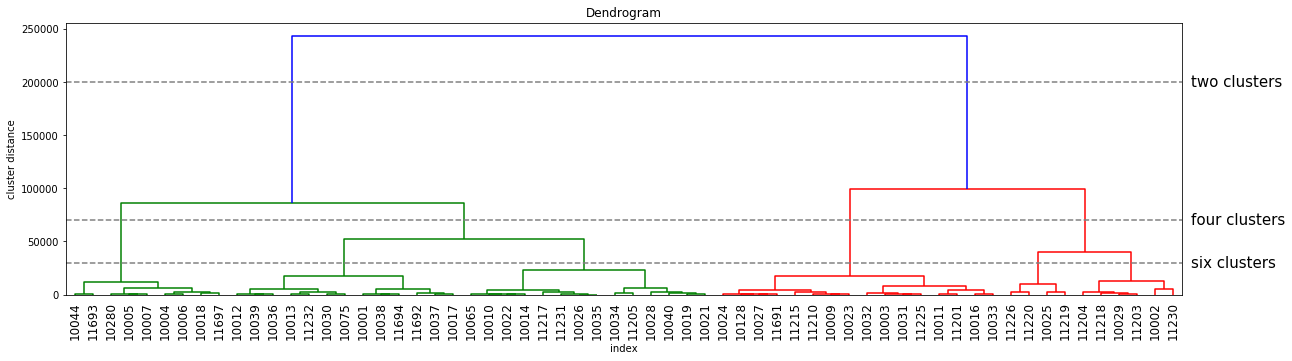

In [7]:
plt.figure(figsize=(20, 5))
linkage_array = ward(df_main)
dendrogram(linkage_array, leaf_font_size=12)

h_line = [200000, 70000, 30000]

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [h_line[0], h_line[0]], '--', c='grey')
ax.plot(bounds, [h_line[1], h_line[1]], '--', c='grey')
ax.plot(bounds, [h_line[2], h_line[2]], '--', c='grey')

ax.text(bounds[1]+5, h_line[0], 'two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[1], 'four clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[2], 'six clusters', va='center', fontdict={'size': 15})

ax.set_xlabel("index")
ax.set_ylabel("cluster distance")
ax.set_xticklabels([df_main.index[int(i.get_text())] for i in ax.get_xticklabels()])
ax.set_title("Dendrogram")
plt.show()

# Baseline

In [162]:
params = {"n_clusters": [3, 4, 5, 6]}
osm = ["shoes_count", "restaurant_count", "gym_count", "clothes_count", "clinic_count"]
df_scaled = np.concatenate((StandardScaler().fit_transform(df_main[["population"]]),  # Gaussian
                            MaxAbsScaler().fit_transform(df_main[osm]),  # Sparse data 
                            df_main[df_main.columns[~df_main.columns.isin(osm+["population"])]].values),  # Percentage
                           axis=1)
cv = 20
for n in params["n_clusters"]:
    scores = list()
    for _ in range(cv):
        base_km = KMeans(n_clusters=n)
        base_km.fit(df_scaled)
        scores.append(silhouette_score(df_main, base_km.labels_))
    _, s2 = cluster_stability(df_scaled, KMeans(n_clusters=n), n_iter=cv)
    print(f"N: {n} | silhouette: {np.mean(scores):.4f} | stability: {s2:.4f}")

N: 3 | silhouette: 0.5964 | stability: 0.5998
N: 4 | silhouette: 0.5326 | stability: 0.5761
N: 5 | silhouette: 0.3872 | stability: 0.6537
N: 6 | silhouette: 0.2572 | stability: 0.7078


# Gradient Descent KMeams w/ SSE Objective Funtion 

In [8]:
N_ROWS, N_FEATURES = df_main.shape
MAT = tf.constant(df_main.values)
WEIGHTS = dict()

In [39]:
def plot_learning_curve(sse_lt, delta_sse_lt, title=""):
    x_axis = range(len(sse_lt))
    
    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.set_xlabel("# epoch")
    ax1.set_ylabel("SSE")
    ax1.set_yscale("log")
    l1 = ax1.plot(x_axis, sse_lt, label="SSE", c="blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel('delta SSE')
    ax2.set_yscale("log")
    l2 = ax2.plot(x_axis, delta_sse_lt, label="delta SSE", c='orange')
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs)
    plt.title(title)
    plt.show()

## Define the SSE Function

In [10]:
def sse_sum(weights, centers, labels):
    sse = tf.zeros([1, N_FEATURES], tf.float64)
    for i in range(N_ROWS):
        sse += (MAT * weights - centers[labels[i]])**2
    return tf.reduce_sum(sse)

## Gradient Function of SSE

In [11]:
grad_sse_sum = tfe.gradients_function(sse_sum, params=[0])

# Gradient Models

In [12]:
def inital_weights_sse(Model, lr):
    weights = tf.ones([1, N_FEATURES], tf.float64)

    mat_w = MAT * weights
    model = Model.fit(mat_w)
    
    centers = model.cluster_centers_
    labels = model.labels_
    sse_cur = sse_sum(weights, centers, labels)

    grad = grad_sse_sum(weights, centers, labels)[0]
    weights = weights - grad / tf.norm(grad) * lr
    weights /= tf.norm(weights)

    return weights, sse_cur

In [13]:
def gradient_kmeans(Model, lr, threshold, sse_prev, **initial):
    delta_sse = initial["delta_sse"] if "delta_sse" in initial else 2*(10**12)
    weights = initial["weights"] if "weights" in initial else tf.ones([1, N_FEATURES], tf.float64)
    
    sse_lt, delta_sse_lt = list(), list()
    while delta_sse > threshold:
        mat_w = MAT * weights
        model = Model.fit(mat_w)
        
        centers = model.cluster_centers_
        labels = model.labels_
        sse_cur = sse_sum(weights, centers, labels)
        

        grad = grad_sse_sum(weights, centers, labels)[0]
        weights = weights - grad / tf.norm(grad) * lr
        weights /= tf.norm(weights)
        
        delta_sse = tf.abs(sse_prev - sse_cur)
        sse_prev = sse_cur
        if not (len(sse_lt) % 50):
            print(f"Iter: {len(sse_lt)}, delta SSE: {delta_sse.numpy()}")
        sse_lt.append(sse_cur)
        delta_sse_lt.append(delta_sse)

    print(f"\nFinal delta SSE: {delta_sse}")   
    return weights, delta_sse_lt, sse_lt 
    

## KMeans (n = 3)

In [14]:
init_w, init_sse = inital_weights_sse(KMeans(n_clusters=3), lr=0.001)

In [15]:
w1, d_sse_lt1, sse_lt1 = gradient_kmeans(KMeans(n_clusters=3), lr=0.001, threshold=150000, 
                                         sse_prev=init_sse, weights=init_w)

Iter: 0, delta SSE: 4609232980649.025
Iter: 50, delta SSE: 1386897305.0841827
Iter: 100, delta SSE: 936681975.896492
Iter: 150, delta SSE: 468102491.75606537

Final delta SSE: 137992.48444164963


In [16]:
w2, d_sse_lt2, sse_lt2 = gradient_kmeans(KMeans(n_clusters=3), lr=0.0001, threshold=15000, 
                                         sse_prev=sse_lt1[-1], weights=w1, delta_sse=d_sse_lt1[-1])

Iter: 0, delta SSE: 138000.128190652
Iter: 50, delta SSE: 17353.10725568328
Iter: 100, delta SSE: 16850.669726038584
Iter: 150, delta SSE: 16400.475232562923
Iter: 200, delta SSE: 15991.179453555262
Iter: 250, delta SSE: 15522.742580989725
Iter: 300, delta SSE: 15266.09364827734

Final delta SSE: 14991.08423895447


In [21]:
w3, d_sse_lt3, sse_lt3 = gradient_kmeans(KMeans(n_clusters=3), lr=0.00001, threshold=1, 
                                         sse_prev=sse_lt1[-1], weights=w2, delta_sse=d_sse_lt2[-1])

Iter: 0, delta SSE: 1108154.7453107215
Iter: 50, delta SSE: 51.01699408085551
Iter: 100, delta SSE: 21.652986171480734
Iter: 150, delta SSE: 10.975851644994691

Final delta SSE: 0.845138048636727


In [18]:
silhouette_score(MAT*w3, KMeans(n_clusters=3).fit(MAT*w3).labels_)

0.5945459323528665

In [19]:
WEIGHTS[3] = w3

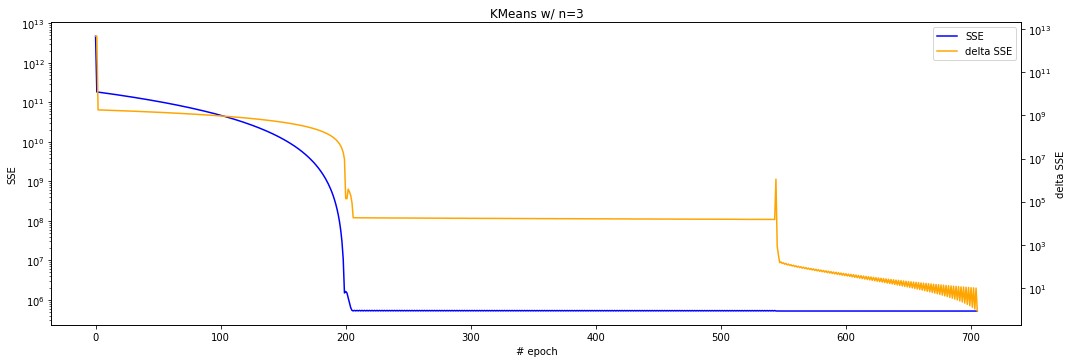

In [40]:
plot_learning_curve([init_sse, *sse_lt1, *sse_lt2, *sse_lt3],
                    [init_sse, *d_sse_lt1, *d_sse_lt2, *d_sse_lt3],
                    title="KMeans w/ n=3")

## KMeans (n=4)

In [42]:
init_w, init_sse = inital_weights_sse(KMeans(n_clusters=4), lr=0.001)
w1, d_sse_lt1, sse_lt1 = gradient_kmeans(KMeans(n_clusters=4), lr=0.001, threshold=150000, 
                                         sse_prev=init_sse, weights=init_w)

Iter: 0, delta SSE: 4781434830558.816
Iter: 50, delta SSE: 1438712031.599762
Iter: 100, delta SSE: 971676578.7667618
Iter: 150, delta SSE: 485590882.9319649

Final delta SSE: 147828.09361058008


In [43]:
w2, d_sse_lt2, sse_lt2 = gradient_kmeans(KMeans(n_clusters=4), lr=0.0001, threshold=15000, 
                                         sse_prev=sse_lt1[-1], weights=w1, delta_sse=d_sse_lt1[-1])

Iter: 0, delta SSE: 147835.73311779252
Iter: 50, delta SSE: 17467.3809506048
Iter: 100, delta SSE: 16800.7310166409
Iter: 150, delta SSE: 16245.141240417957
Iter: 200, delta SSE: 16068.385959200794

Final delta SSE: 14850.251090271864


In [44]:
w3, d_sse_lt3, sse_lt3 = gradient_kmeans(KMeans(n_clusters=4), lr=0.00001, threshold=1, 
                                         sse_prev=sse_lt1[-1], weights=w2, delta_sse=d_sse_lt2[-1])

Iter: 0, delta SSE: 1163160.9554662472
Iter: 50, delta SSE: 13.510812674532644
Iter: 100, delta SSE: 2.3330682361265644

Final delta SSE: 0.9112119880737737


In [47]:
WEIGHTS[4] = w3
silhouette_score(MAT*w3, KMeans(n_clusters=4).fit(MAT*w3).labels_)

0.5601012578483291

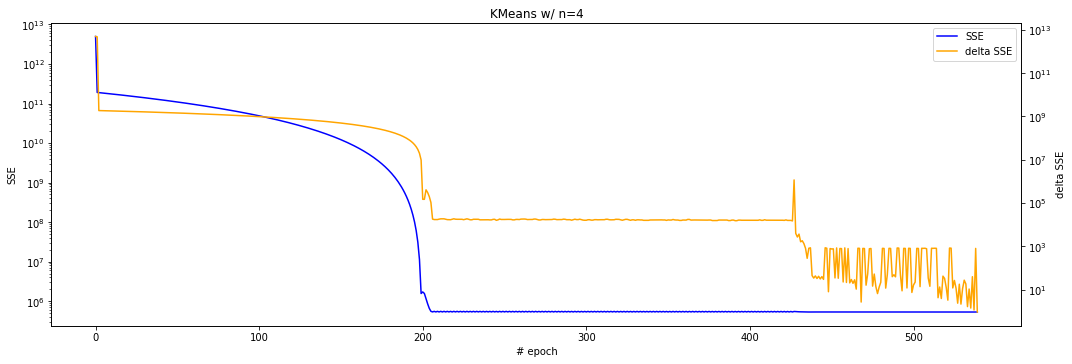

In [48]:
plot_learning_curve([init_sse, *sse_lt1, *sse_lt2, *sse_lt3],
                    [init_sse, *d_sse_lt1, *d_sse_lt2, *d_sse_lt3],
                    title="KMeans w/ n=4")

## KMeans (n=5)

In [145]:
init_w, init_sse = inital_weights_sse(KMeans(n_clusters=5), lr=0.0004)
w1, d_sse_lt1, sse_lt1 = gradient_kmeans(KMeans(n_clusters=5), lr=0.0004, threshold=150000, 
                                         sse_prev=init_sse, weights=init_w)

Iter: 0, delta SSE: 4837455532003.745
Iter: 50, delta SSE: 689808833.9180603
Iter: 100, delta SSE: 618131993.2799377
Iter: 150, delta SSE: 544552459.7892151
Iter: 200, delta SSE: 469281775.4064026
Iter: 250, delta SSE: 392542518.8887787
Iter: 300, delta SSE: 314566954.77861404
Iter: 350, delta SSE: 235595573.72613525
Iter: 400, delta SSE: 155875539.4682598
Iter: 450, delta SSE: 75659059.38267183

Final delta SSE: 27501.375601039967


In [147]:
w2, d_sse_lt2, sse_lt2 = gradient_kmeans(KMeans(n_clusters=5), lr=0.00001, threshold=1, 
                                         sse_prev=sse_lt1[-1], weights=w1, delta_sse=d_sse_lt1[-1])

Iter: 0, delta SSE: 26727.73383336654
Iter: 50, delta SSE: 59.84295717894565
Iter: 100, delta SSE: 18.723058275296353
Iter: 150, delta SSE: 4.235858583007939

Final delta SSE: 0.9664333940017968


In [149]:
WEIGHTS[5] = w2
silhouette_score(MAT*w2, KMeans(n_clusters=5).fit(MAT*w2).labels_)

0.5683018209382807

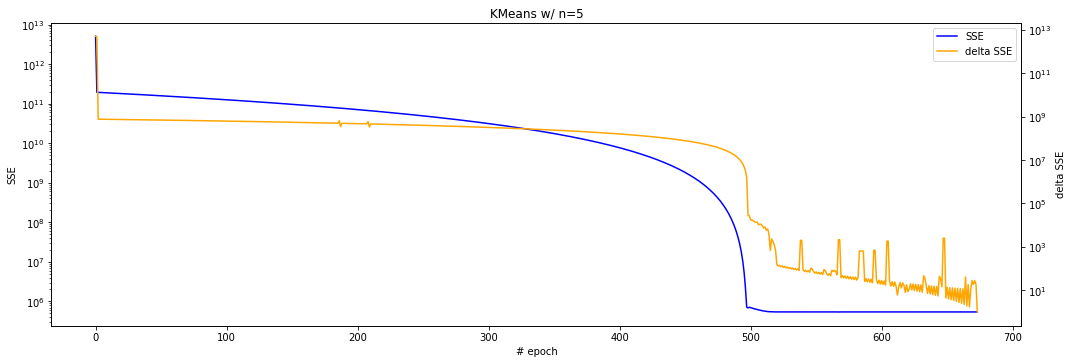

In [148]:
plot_learning_curve([init_sse, *sse_lt1, *sse_lt2],
                    [init_sse, *d_sse_lt1, *d_sse_lt2],
                    title="KMeans w/ n=5")

## KMeans (n=6)

In [150]:
init_w, init_sse = inital_weights_sse(KMeans(n_clusters=6), lr=0.0004)
w1, d_sse_lt1, sse_lt1 = gradient_kmeans(KMeans(n_clusters=6), lr=0.0004, threshold=150000, 
                                         sse_prev=init_sse, weights=init_w)

Iter: 0, delta SSE: 4884362787228.226
Iter: 50, delta SSE: 696497698.9190063
Iter: 100, delta SSE: 624125829.9090424
Iter: 150, delta SSE: 549832818.2165375
Iter: 200, delta SSE: 473832257.0597534
Iter: 250, delta SSE: 396348883.473938
Iter: 300, delta SSE: 317617214.19942856
Iter: 350, delta SSE: 237880071.8507347
Iter: 400, delta SSE: 157387016.835783
Iter: 450, delta SSE: 76392702.10984254

Final delta SSE: 29880.115643891622


In [151]:
w2, d_sse_lt2, sse_lt2 = gradient_kmeans(KMeans(n_clusters=6), lr=0.00001, threshold=1, 
                                         sse_prev=sse_lt1[-1], weights=w1, delta_sse=d_sse_lt1[-1])

Iter: 0, delta SSE: 29996.665326367714
Iter: 50, delta SSE: 59.78887431009207
Iter: 100, delta SSE: 18.677678248262964
Iter: 150, delta SSE: 55.665074199438095

Final delta SSE: 0.8531958312960342


In [152]:
WEIGHTS[6] = w2
silhouette_score(MAT*w2, KMeans(n_clusters=5).fit(MAT*w2).labels_)

0.5681650447738831

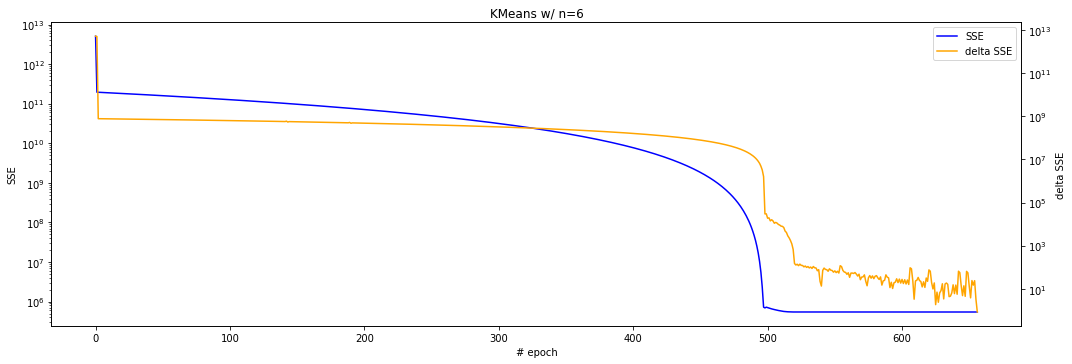

In [154]:
plot_learning_curve([init_sse, *sse_lt1, *sse_lt2],
                    [init_sse, *d_sse_lt1, *d_sse_lt2],
                    title="KMeans w/ n=6")

In [174]:
for n, w in WEIGHTS.items():
    s1 = silhouette_score(MAT*w, KMeans(n_clusters=n).fit(MAT*w).labels_) 
    _, s2 = cluster_stability(MAT*w, KMeans(n_clusters=n))
    print(f"N: {n} | silhouette: {s1:.4f} | stability: {s2:.4f}")
#     silhouette_plot((MAT*w).numpy(), KMeans(n_clusters=n).fit(MAT*w).labels_, n)

N: 3 | silhouette: 0.5945 | stability: 0.8761
N: 4 | silhouette: 0.5839 | stability: 0.8328
N: 5 | silhouette: 0.5683 | stability: 0.8288
N: 6 | silhouette: 0.4930 | stability: 0.7489


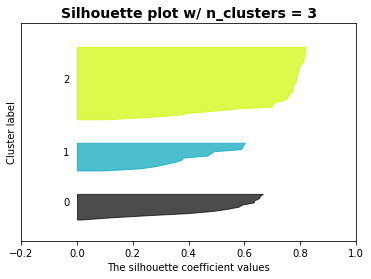

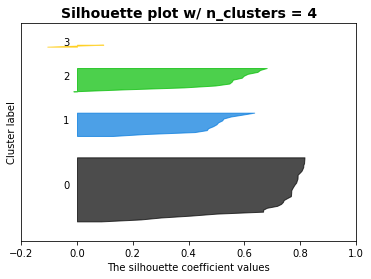

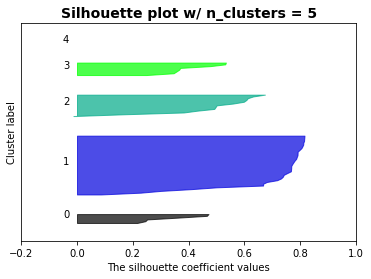

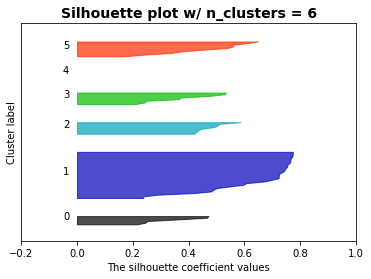

In [175]:
for n, w in WEIGHTS.items():
    silhouette_plot((MAT*w).numpy(), KMeans(n_clusters=n).fit(MAT*w).labels_, n)

In [187]:
km = KMeans(n_clusters=3)
km.fit(MAT*WEIGHTS[3])
km.labels_

array([1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 2, 1, 1,
       1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1], dtype=int32)

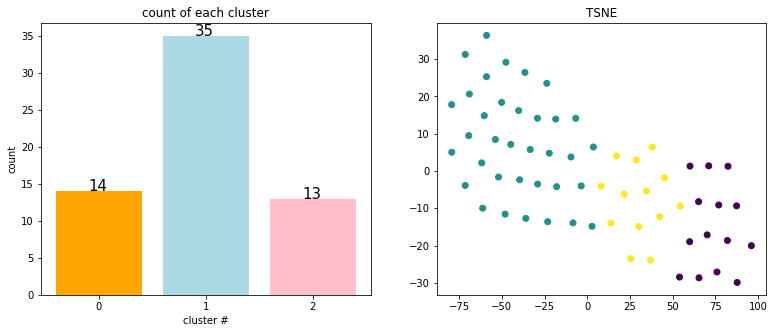

In [209]:
count = Counter(km.labels_)
x_cluster, y_height = zip(*count.items())

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.bar(x=x_cluster, height=y_height, tick_label=x_cluster, color=["lightblue", "orange", "pink"])
for i, j in count.items(): 
    plt.text(x=i-.1, y=j, s=j, fontdict={"fontsize": 15})
plt.ylabel("count")
plt.xlabel("cluster #")
plt.title("count of each cluster")

plt.subplot(1, 2, 2)
tsne_embedded = TSNE(n_components=2).fit_transform(MAT*WEIGHTS[3])
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=km.labels_)
plt.title("TSNE")
plt.show()

In [210]:
C = [km.labels_==0,
     km.labels_==1,
     km.labels_==2]

cluster_zip_code = {i: df_main[c].index for i, c in enumerate(C)}
"Cluster's Zip Code", cluster_zip_code

("Cluster's Zip Code",
 {0: Int64Index([10001, 10011, 10019, 10036, 10016, 10012, 10013, 10014, 10002,
              10003, 10025, 11201, 11215, 11217],
             dtype='int64'),
  1: Int64Index([10026, 10027, 10030, 10037, 10039, 10035, 10005, 10006, 10007,
              10280, 10021, 10044, 10065, 10075, 10031, 10032, 10033, 10034,
              10040, 11691, 11692, 11693, 11694, 11697, 11204, 11218, 11219,
              11230, 11205, 11203, 11210, 11225, 11226, 11220, 11232],
             dtype='int64'),
  2: Int64Index([10018, 10029, 10010, 10017, 10022, 10004, 10038, 10009, 10028,
              10128, 10023, 10024, 11231],
             dtype='int64')})

In [213]:
pickle.dump(cluster_zip_code, open("cluster_weight_zip_code.pkl", "wb"))
pickle.dump(km, open('kmeans_weight.pkl', 'wb'))